MSc Data Science Thesis code. \
Predicting the probability of critical illness insurance claims as a form of noncommunicable disease management. \
This is the second of two notebooks demonstrating the application of the proposed approach. \
Details of the proposed approach can be found in the proposed_methodology.py script. \
In this notebook, critical illness claims are modelled using critical illness insurance coverage information, client demographic information, and health claims from clients' health insurance.

# Project Set up

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from dateutil.relativedelta import relativedelta
from scipy.stats import randint, loguniform, uniform

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
from proposed_methodology import ProposedMethodology
from create_data_partitions import create_train_test, create_claim_train_test

In [5]:
%aimport proposed_methodology, create_data_partitions

In [6]:
sns.set()

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3}'.format)

In [8]:
pd.__version__

'2.2.3'

# Load Dataset

## Claims

In [9]:
claims = pd.read_csv('DATA/HEALTH_CLAIMS.csv')

In [10]:
#Some columns of the dataset are private
display_cols_claims = ['CLAIM_ID', 'CLAIM_PROCEDURE_ID', 'PROCEDURE_CODE', 'PROCEDURE_GROUP', 
                       'CLAIM_DIAGNOSIS_ID', 'DIAGNOSIS_CODE', 'DIAGNOSIS_GROUP', 
                       'CHARGES', 'CLAIM_LENGTH', 'PROCEDURE_LENGTH', 'EOB_CATEGORY', 'STATUS', 'PROCEDURE_STATUS', 'CLAIM_DT']

In [11]:
claims.loc[:, display_cols_claims].head()

,CLAIM_ID,CLAIM_PROCEDURE_ID,PROCEDURE_CODE,PROCEDURE_GROUP,CLAIM_DIAGNOSIS_ID,DIAGNOSIS_CODE,DIAGNOSIS_GROUP,CHARGES,CLAIM_LENGTH,PROCEDURE_LENGTH,EOB_CATEGORY,STATUS,PROCEDURE_STATUS,CLAIM_DT
0,2525285,5642243,D1110,DENTAL,3120020,Z01.20,DENTAL,4.8e+02,0.0,0,4_PASS,CLOSED,APP,2021-12-10
1,2525285,5642242,D0120,DENTAL,3120020,Z01.20,DENTAL,2.3e+02,0.0,0,4_PASS,CLOSED,APP,2021-12-10
2,2525285,5642244,D0274,DENTAL,3120020,Z01.20,DENTAL,1.8e+02,0.0,0,5_NONE,CLOSED,APP,2021-12-10
3,1313265,2848966,99201,VISIT,1604812,611.72,CANCER/GROWTH,2.7e+02,0.0,0,4_PASS,CLOSED,DENY,2016-05-23
4,1313266,2848969,80048,TEST,1604813,611.72,CANCER/GROWTH,5e+02,0.0,0,4_PASS,CLOSED,DENY,2016-05-23


In [106]:
print('Size of dataset: ', claims.shape)
print('Number of unique clients: ', claims['MDM_ID'].nunique())
print('Number of health claims observed:', claims['CLAIM_ID'].nunique())

Size of dataset:  (158883, 18)
Number of unique clients:  2224
Number of health claims observed: 68624


In [13]:
#Convert columns to datetime format
#There are other date columns but these are ignored
cols = ['CLAIM_DT']
for col in cols:
    claims.loc[:, col] = pd.to_datetime(claims[col])

In [14]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
claims = claims.convert_dtypes(convert_floating=False, convert_integer=False)

In [15]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158883 entries, 0 to 158882
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CLAIM_ID            158883 non-null  int64         
 1   MDM_ID              158883 non-null  int64         
 2   CLAIM_PROCEDURE_ID  158883 non-null  int64         
 3   PROCEDURE_CODE      158883 non-null  string        
 4   PROCEDURE_GROUP     158883 non-null  string        
 5   CLAIM_DIAGNOSIS_ID  158883 non-null  int64         
 6   DIAGNOSIS_CODE      158883 non-null  string        
 7   DIAGNOSIS_GROUP     158883 non-null  string        
 8   CHARGES             158883 non-null  float64       
 9   CLAIM_LENGTH        158454 non-null  float64       
 10  PROCEDURE_LENGTH    158883 non-null  int64         
 11  EOB_CATEGORY        158883 non-null  string        
 12  STATUS              158883 non-null  string        
 13  PROCEDURE_STATUS    158883 no

## Coverages

In [16]:
cvg = pd.read_csv('DATA/CI_CVGS.csv')

In [17]:
#Some columns of the dataset are private
display_cols_cvg = ['CLAIM', 'START_AGE', 'TENURE', 'MATURITY_AGE', 'TIME_TO_MATURE', 
                    'SEX_CD', 'SUM_INSURED', 'SMOKER', 'MARITAL_STATUS', 'INCOME', 'YEARS_EMPLOYED']

In [18]:
cvg.loc[:, display_cols_cvg].head()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SEX_CD,SUM_INSURED,SMOKER,MARITAL_STATUS,INCOME,YEARS_EMPLOYED
0,0,42,149,70,10078,M,1e+05,0,UNKNOWN,5000,13
1,0,36,303,65,10289,M,1e+05,0,UNKNOWN,12000,1
2,0,28,918,65,12596,F,1e+06,0,UNKNOWN,0,0
3,0,33,3291,65,8397,M,2.5e+05,0,MARRIED,1666,6
4,0,40,728,65,8403,F,2.5e+05,0,MARRIED,8333,10


In [19]:
print('Size of dataset: ', cvg.shape)
print('Number of unique clients: ', cvg['MDM_ID'].nunique())
print('Number of CI claims observed:', cvg['CLAIM'].sum())

Size of dataset:  (110402, 18)
Number of unique clients:  89510
Number of CI claims observed: 2135


In [20]:
#Convert columns to datetime format
cols = ['START_DT', 'END_DT', 'DOB', 'MATURITY_DT']
for col in cols:
    cvg.loc[:, col] = pd.to_datetime(cvg[col])

In [21]:
#Convert columns to appropriate formats, prevent pandas nullable types as these are incompatible with sci-kit
cvg = cvg.convert_dtypes(convert_floating=False, convert_integer=False)

In [22]:
cvg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110402 entries, 0 to 110401
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   MDM_ID          110402 non-null  int64         
 1   CLI_ID          110402 non-null  int64         
 2   CVG_ID          110402 non-null  string        
 3   CLAIM           110402 non-null  int64         
 4   START_AGE       110402 non-null  int64         
 5   TENURE          110402 non-null  int64         
 6   START_DT        110402 non-null  datetime64[ns]
 7   END_DT          110402 non-null  datetime64[ns]
 8   MATURITY_AGE    110402 non-null  int64         
 9   MATURITY_DT     110402 non-null  datetime64[ns]
 10  TIME_TO_MATURE  110402 non-null  int64         
 11  SEX_CD          110402 non-null  string        
 12  SUM_INSURED     110402 non-null  float64       
 13  SMOKER          110402 non-null  int64         
 14  MARITAL_STATUS  110402 non-null  str

In [23]:
cvg.loc[:, display_cols_cvg].describe()

,CLAIM,START_AGE,TENURE,MATURITY_AGE,TIME_TO_MATURE,SUM_INSURED,SMOKER,INCOME,YEARS_EMPLOYED
count,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05,1.1e+05
mean,0.0193,32.2,1.96e+03,67.5,1.1e+04,2.01e+05,0.0925,1.09e+04,6.49
std,0.138,8.89,2.2e+03,3.55,4.08e+03,2.07e+05,0.325,4.36e+04,7.24
min,0.0,14.0,21.0,64.0,0.0,2e+04,-1.0,0.0,0.0
25%,0.0,25.0,4.17e+02,65.0,8.47e+03,1e+05,0.0,5e+03,1.0
50%,0.0,31.0,1e+03,65.0,1.15e+04,1.25e+05,0.0,7.5e+03,4.0
75%,0.0,38.0,2.79e+03,70.0,1.39e+04,2.3e+05,0.0,1.2e+04,10.0
max,1.0,65.0,1.31e+04,81.0,2.33e+04,8e+06,1.0,7e+06,82.0


# Feature engineering
- Latest age variable
- Encoding

## Coverages

### Variables

In [24]:
cvg.loc[:, 'LAST_AGE'] = cvg.apply(lambda x: x['START_AGE'] + relativedelta(x['END_DT'], x['START_DT']).years , axis=1)

In [25]:
#Data entry issues and date-time calculation sensitivity causes values to be imprecise, this is corrected here. 
#The maximum age on the insurance can only be 65, 70, 75 or 80.
cvg.loc[cvg['MATURITY_AGE'].between(60, 66), 'MATURITY_AGE'] = 65
cvg.loc[cvg['MATURITY_AGE'].between(67, 71), 'MATURITY_AGE'] = 70
cvg.loc[cvg['MATURITY_AGE'].between(72, 76), 'MATURITY_AGE'] = 75
cvg.loc[cvg['MATURITY_AGE'].between(77, 82), 'MATURITY_AGE'] = 80

### Encoding

In [26]:
#Sex
cvg.loc[:, 'SEX_F'] = np.where(cvg['SEX_CD'] == 'F', 1, 0)
cvg.loc[:, 'SEX_M'] = np.where(cvg['SEX_CD'] == 'M', 1, 0)

In [27]:
cvg[['SEX_CD', 'SEX_F', 'SEX_M']].value_counts()

SEX_CD  SEX_F  SEX_M
F       1      0        56077
M       0      1        54325
Name: count, dtype: int64

In [28]:
#Smoker
cvg.loc[:, 'SMOKER_Y'] = np.where(cvg['SMOKER'] == 1, 1, 0)
cvg.loc[:, 'SMOKER_N'] = np.where(cvg['SMOKER'] != 1, 1, 0)

In [29]:
cvg[['SMOKER', 'SMOKER_Y','SMOKER_N']].value_counts()

SMOKER  SMOKER_Y  SMOKER_N
 0      0         1           97805
 1      1         0           11402
-1      0         1            1195
Name: count, dtype: int64

In [30]:
#Marital status
cvg.loc[:, 'MARITAL_STATUS_SINGLE'] = np.where(cvg['MARITAL_STATUS'] == 'SINGLE', 1, 0)
cvg.loc[:, 'MARITAL_STATUS_MARRIED'] = np.where(cvg['MARITAL_STATUS'] == 'MARRIED', 1, 0)
cvg.loc[:, 'MARITAL_STATUS_OTHER'] = np.where(cvg['MARITAL_STATUS'].isin(['COMMONLAW', 'SEPARATED', 'OTHER', 'UNKNOWN']), 1, 0)

In [31]:
cvg[['MARITAL_STATUS', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER']].value_counts()

MARITAL_STATUS  MARITAL_STATUS_SINGLE  MARITAL_STATUS_MARRIED  MARITAL_STATUS_OTHER
SINGLE          1                      0                       0                       57754
MARRIED         0                      1                       0                       41666
COMMONLAW       0                      0                       1                        6322
SEPARATED       0                      0                       1                        3958
UNKNOWN         0                      0                       1                         528
OTHER           0                      0                       1                         174
Name: count, dtype: int64

## Claims

### Variables

In [32]:
claims.isna().sum()

CLAIM_ID                  0
MDM_ID                    0
CLAIM_PROCEDURE_ID        0
PROCEDURE_CODE            0
PROCEDURE_GROUP           0
CLAIM_DIAGNOSIS_ID        0
DIAGNOSIS_CODE            0
DIAGNOSIS_GROUP           0
CHARGES                   0
CLAIM_LENGTH            429
PROCEDURE_LENGTH          0
EOB_CATEGORY              0
STATUS                    0
PROCEDURE_STATUS          0
CLAIM_DT                  0
ISSUE_DT                  0
TERM_DT               12351
dtype: int64

In [33]:
#Coalesce claim length and procedure length into claim duration variable
claims.loc[:, 'CLAIM_DURATION'] = claims['CLAIM_LENGTH'].combine_first(claims['PROCEDURE_LENGTH'])

In [34]:
#Shorten diagnosis group name
claims.loc[:, 'DIAGNOSIS_GROUP'] = claims['DIAGNOSIS_GROUP'].replace('CANCER/GROWTH', 'CANCER')

### Remove claims after end dates
Health claims made after the closure of the client's critical illness coverage are not applicable and must be removed.

In [35]:
#Merge critical illness coverage dates into the claims dataset
claims_clean = claims.merge(cvg.loc[:, ['MDM_ID', 'CVG_ID', 'START_DT', 'END_DT']], how='inner', on=['MDM_ID'], validate="m:m")

In [36]:
print('Number of instances without an end date, should be zero: ', claims_clean['END_DT'].isna().sum())

Number of instances without an end date, should be zero:  0


In [37]:
#Remove any claim with a date after the end date of the CI coverage
claims_clean = claims_clean.query('CLAIM_DT <= END_DT')
claims_clean.shape

(95047, 21)

### Remove invalid claims
Now we remove claims with invalid status labels or that violate business rules.

In [38]:
claims_clean['STATUS'].value_counts()

STATUS
CLOSED      94767
PENDING       153
APPROVED      127
Name: count, dtype: Int64

In [39]:
claims_clean['PROCEDURE_STATUS'].value_counts()

PROCEDURE_STATUS
APP     77080
DENY    17883
PEND       84
Name: count, dtype: Int64

In [40]:
claims_clean['EOB_CATEGORY'].value_counts()

EOB_CATEGORY
4_PASS           49295
1_NOT_COVERED    23755
5_NONE           18512
3_PENDING         3201
2_INVALID          284
Name: count, dtype: Int64

In [41]:
#Claims must be fully processed, STATUS == CLOSED
#Claim procedure must be approved, PROCEDURE_STATUS == APP
#The claim should have passed business rules checks or had no rules applied to it, EOB_CATEGORY=='4_PASS' or EOB_CATEGORY== '5_NONE'
query = "STATUS=='CLOSED' & PROCEDURE_STATUS=='APP' & (EOB_CATEGORY=='4_PASS' | EOB_CATEGORY== '5_NONE')"
claims_valid = claims_clean.query(query).copy()
claims_valid.shape

(64314, 21)

### Days from previous
Variables such as days since previous claim and claim freqeuncy can now be calculated using the cleaned dataset.

In [42]:
#Days from previous claim calculation.
#Claims must be in the correct order by the date it was made.
def days_from_prev(g):
    df = g.sort_values('CLAIM_DT')
    df.loc[:, 'DAYS_FROM_PREVIOUS'] = df['CLAIM_DT'].diff().dt.days
    return df

In [43]:
#Each claim can have several items or 'lines'.
#We only want one instance of each claim so duplicates are dropped.
days_from_prev_calc = claims_valid.loc[:, ['CVG_ID', 'CLAIM_ID', 'CLAIM_DT']]\
                                  .drop_duplicates()\
                                  .groupby(['CVG_ID'])\
                                  .apply(lambda g: days_from_prev(g), include_groups=False)\
                                  .reset_index()\
                                  .drop(columns=['level_1'])

#The first claim will have NA days from previous
days_from_prev_calc.head(5)

,CVG_ID,CLAIM_ID,CLAIM_DT,DAYS_FROM_PREVIOUS
0,1002561902224620248-01,169618,2008-03-13,NaN
1,1002561902224620248-01,170775,2008-03-18,5.0
2,1002561902224620248-01,235341,2008-08-28,1.63e+02
3,1002561902224620248-01,394629,2009-11-16,4.45e+02
4,1002561902224620248-01,394628,2009-11-16,0.0


In [44]:
#Merge days from previous values into the dataset
claims_final = claims_valid.merge(days_from_prev_calc, how='inner', on=['CVG_ID', 'CLAIM_ID', 'CLAIM_DT'], validate='m:1').copy()

# Modelling datasets
Here the major partitions of the data are demonstrated. Test sets contained CI coverages ending after 2023 and 2024. All other data up to the year of the test set were used for training and validation. Validation sets were created through ScikitLearn’s (SKL) TimeSeriesSplit CV. Claims are aggregated into the coverage dataset. This process is embedded in the proposed method code so this section is for illustrative purposes only.

In [45]:
partitions = pd.DataFrame(columns=['year', 'part', 'cvg', 'proportion', 'cli', 'claims', 'claim_percent'])
for year in [2023, 2024]:
    X_feat, X_label, Y_feat, Y_label, Y_id = create_claim_train_test(cvg, claims_final, cvg.columns, year, 0)
    X_size = X_feat.shape[0]
    Y_size = Y_feat.shape[0]
    Tot_size = X_feat.shape[0] + Y_feat.shape[0]
    
    train_cvg, test_cvg = X_feat['SCALAR_CVG_ID'].nunique(), Y_feat['SCALAR_CVG_ID'].nunique() 
    train_cli, test_cli = X_feat['SCALAR_MDM_ID'].nunique(), Y_feat['SCALAR_MDM_ID'].nunique() 
    train_claims, test_claims = X_label.sum(), Y_label.sum() 
    train_per, test_per = X_label.mean(), Y_label.mean()
    train_size, test_size = X_size/Tot_size, Y_size/Tot_size
    
    partitions.loc[len(partitions), :] = [year, 'train', train_cvg, train_size, train_cli, train_claims, train_per]
    partitions.loc[len(partitions), :] = [year, 'test', test_cvg, test_size, test_cli, test_claims, test_per]

In [46]:
partitions

,year,part,cvg,proportion,cli,claims,claim_percent
0,2023,train,1213,0.69,1000,53,0.0437
1,2023,test,545,0.31,498,18,0.033
2,2024,train,1506,0.857,1231,59,0.0392
3,2024,test,252,0.143,239,12,0.0476


# Missing Data Handling
- Check for number of nulls
     - If entire column is null drop column
     - If entire row is null drop row
- Replace outliers and missing values with median as appropriate

In [47]:
model_cols = ['LAST_AGE', 'START_AGE', 'TENURE', 'TIME_TO_MATURE', 'MATURITY_AGE', 
              'SUM_INSURED', 'INCOME', 'YEARS_EMPLOYED', 
              'SEX_F', 'SEX_M', 'SMOKER_Y', 'SMOKER_N', 
              'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER', 
              'NUM_CLAIMS', 'NUM_PROCEDURE', 'NUM_DIAGNOSIS', 'TOTAL_CHARGES', 'AVG_CHARGE', 
              'NUM_PROCEDURE_DENTAL', 'NUM_PROCEDURE_DRUGS', 'NUM_PROCEDURE_HOSPITAL', 'NUM_PROCEDURE_OTHER', 
              'NUM_PROCEDURE_SERVICE', 'NUM_PROCEDURE_TEST', 'NUM_PROCEDURE_VACCINATION', 'NUM_PROCEDURE_VISION', 
              'NUM_PROCEDURE_VISIT', 
              'NUM_DIAGNOSIS_CANCER', 'NUM_DIAGNOSIS_CARDIAC', 'NUM_DIAGNOSIS_CHRONIC', 'NUM_DIAGNOSIS_COMMON', 
              'NUM_DIAGNOSIS_DENTAL', 'NUM_DIAGNOSIS_EXAM', 'NUM_DIAGNOSIS_INFECTION', 'NUM_DIAGNOSIS_INJURY', 
              'NUM_DIAGNOSIS_ORGAN', 'NUM_DIAGNOSIS_OTHER', 'NUM_DIAGNOSIS_PAIN', 'NUM_DIAGNOSIS_RESPIRATORY', 
              'NUM_DIAGNOSIS_SEXUAL', 'NUM_DIAGNOSIS_VISION', 
              'AVG_CLAIM_DURATION', 'MAX_CLAIM_DURATION', 'CLAIM_FREQUENCY']

In [48]:
#The final dataset is created on demand in the method code, so we must create one
df_mod, *_ = create_claim_train_test(cvg, claims_final, model_cols, 2025, 0)

In [49]:
df_mod.shape

(1758, 46)

In [50]:
df_mod.isna().sum()

SCALAR_LAST_AGE                     0
SCALAR_START_AGE                    0
SCALAR_TENURE                       0
SCALAR_TIME_TO_MATURE               0
SCALAR_MATURITY_AGE                 0
SCALAR_SUM_INSURED                  0
SCALAR_INCOME                       0
SCALAR_YEARS_EMPLOYED               0
CATEGORY_SEX_F                      0
CATEGORY_SEX_M                      0
CATEGORY_SMOKER_Y                   0
CATEGORY_SMOKER_N                   0
CATEGORY_MARITAL_STATUS_SINGLE      0
CATEGORY_MARITAL_STATUS_MARRIED     0
CATEGORY_MARITAL_STATUS_OTHER       0
SCALAR_NUM_CLAIMS                   0
SCALAR_NUM_PROCEDURE                0
SCALAR_NUM_DIAGNOSIS                0
SCALAR_TOTAL_CHARGES                0
SCALAR_AVG_CHARGE                   0
SCALAR_NUM_PROCEDURE_DENTAL         0
SCALAR_NUM_PROCEDURE_DRUGS          0
SCALAR_NUM_PROCEDURE_HOSPITAL       0
SCALAR_NUM_PROCEDURE_OTHER          0
SCALAR_NUM_PROCEDURE_SERVICE        0
SCALAR_NUM_PROCEDURE_TEST           0
SCALAR_NUM_P

In [51]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758 entries, 1351 to 1137
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SCALAR_LAST_AGE                   1758 non-null   int64  
 1   SCALAR_START_AGE                  1758 non-null   int64  
 2   SCALAR_TENURE                     1758 non-null   int64  
 3   SCALAR_TIME_TO_MATURE             1758 non-null   int64  
 4   SCALAR_MATURITY_AGE               1758 non-null   int64  
 5   SCALAR_SUM_INSURED                1758 non-null   float64
 6   SCALAR_INCOME                     1758 non-null   int64  
 7   SCALAR_YEARS_EMPLOYED             1758 non-null   int64  
 8   CATEGORY_SEX_F                    1758 non-null   int64  
 9   CATEGORY_SEX_M                    1758 non-null   int64  
 10  CATEGORY_SMOKER_Y                 1758 non-null   int64  
 11  CATEGORY_SMOKER_N                 1758 non-null   int64  
 12  CATEGORY

# Proposed approach
The proposed approach consists of the following steps:
1. Test the 5 Machine Learning algorithms to find the model that produces the best probability estimates.
2. Select the best performing model and produce critical illness claim probability estimates for each insurance coverage.
3. Rank the coverages in order of risk and assess the ranking.

In this section we evaluate the 5 ML algorithms. \
The evaluation involves two test sets corresponding to coverages ending in 2023 and 2024. \
Additionally, time-sensitive features in the dataset are offset by interval values of 0, 90, 180, and 360 days to simulate whether the model can make accurate predictions ahead of time. This can grant up to 1 year of intervention time.

In [52]:
n_jobs = -1

In [53]:
#Limits for outlier handling via Winsorisation
#The tuple is structured as follows:
#1. Column to be adjusted, 2. Lower inlier bound, 3. Upper inlier bound
outlier_bounds = [('SCALAR_SUM_INSURED', 20000, 3e6),
                  ('SCALAR_INCOME', 0, 2e5),
                  ('SCALAR_YEARS_EMPLOYED', 0, 50)]

In [54]:
#Columns used to build the predictive model. 
#Includes coverage details, client demographic information, and health claim aggregate features.
model_cols = ['LAST_AGE', 'START_AGE', 'TENURE', 'TIME_TO_MATURE', 'MATURITY_AGE', 
              'SUM_INSURED', 'INCOME', 'YEARS_EMPLOYED', 
              'SEX_F', 'SEX_M', 'SMOKER_Y', 'SMOKER_N', 
              'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_OTHER', 
              'NUM_CLAIMS', 'NUM_PROCEDURE', 'NUM_DIAGNOSIS', 'TOTAL_CHARGES', 'AVG_CHARGE', 
              'NUM_PROCEDURE_DENTAL', 'NUM_PROCEDURE_DRUGS', 'NUM_PROCEDURE_HOSPITAL', 'NUM_PROCEDURE_OTHER', 
              'NUM_PROCEDURE_SERVICE', 'NUM_PROCEDURE_TEST', 'NUM_PROCEDURE_VACCINATION', 'NUM_PROCEDURE_VISION', 
              'NUM_PROCEDURE_VISIT', 
              'NUM_DIAGNOSIS_CANCER', 'NUM_DIAGNOSIS_CARDIAC', 'NUM_DIAGNOSIS_CHRONIC', 'NUM_DIAGNOSIS_COMMON', 
              'NUM_DIAGNOSIS_DENTAL', 'NUM_DIAGNOSIS_EXAM', 'NUM_DIAGNOSIS_INFECTION', 'NUM_DIAGNOSIS_INJURY', 
              'NUM_DIAGNOSIS_ORGAN', 'NUM_DIAGNOSIS_OTHER', 'NUM_DIAGNOSIS_PAIN', 'NUM_DIAGNOSIS_RESPIRATORY', 
              'NUM_DIAGNOSIS_SEXUAL', 'NUM_DIAGNOSIS_VISION', 
              'AVG_CLAIM_DURATION', 'MAX_CLAIM_DURATION', 'CLAIM_FREQUENCY']

In [55]:
max_features = len(model_cols) + 1
print('Max features: ', max_features)

Max features:  47


In [56]:
#Init the proposed methodology class
#Experiments are repeated 20 times
pm = ProposedMethodology(cvg, model_cols, outlier_bounds, claims_final, runs=20)

In [57]:
#Set the parameters for the experiment,
#Two test years 2023, 2024
#Four offset intervals 0, 90, 180, 360
pm.set_params(test_years=[2023,2024], test_intervals=[0,90,180,360])

## Dummy classifier
It is useful to compare the results of each classifier to that of a dummy classifier.

In [58]:
scores_base = pm.dummy_results()

In [59]:
scores_base

,year,log_loss,roc_auc
0,2023,0.145,0.5
1,2024,0.191,0.5


## Logistic Regression with Elastic Net

In [60]:
lren = LogisticRegression(random_state=0, penalty='elasticnet', solver='saga', n_jobs=n_jobs)

In [61]:
#Parameter grid for the grid search with the logistic regression classifier
cv_params_lren = {
    "estimator__clf__tol": loguniform(b=1e-4, a=1e-8),
    "estimator__clf__C": loguniform(b=1e1, a=1e-1),
    "estimator__clf__l1_ratio": uniform(),
    "estimator__clf__max_iter": [10000],
    "estimator__clf__fit_intercept": [True]
}

In [62]:
#Run the experiment for this classifier and print the time it took
#Test 20 parameter combinations
start = time.time()
cls_results_lren, cls_means_lren, opt_params_lren = pm.probability_estimation(lren, cv_params_lren, 20, 5)
end = time.time()
print((end - start)/60)

35.526586564381915


In [63]:
cls_means_lren

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.102,0.297,0.884
1,2023,90,0.117,0.218,0.86
2,2023,180,0.135,0.128,0.847
3,2023,360,0.139,0.149,0.846
4,2024,0,0.116,0.395,0.914
5,2024,90,0.142,0.284,0.862
6,2024,180,0.169,0.17,0.867
7,2024,360,0.172,0.202,0.88


## SVM

In [64]:
svm = SVC(random_state=0, kernel='rbf')

In [65]:
#Parameter grid for the grid search with the SVM classifier
cv_params_svm = {
    "estimator__clf__tol": loguniform(b=1e-4, a=1e-8),
    "estimator__clf__C": loguniform(b=1e1, a=1e-1),
    "estimator__clf__gamma": loguniform(b=1e0, a=1e-8),
    "estimator__clf__max_iter": [10000],
}

In [66]:
#Run the experiment for this classifier and print the time it took
#Test 20 parameter combinations
start = time.time()
cls_results_svm, cls_means_svm, opt_params_svm = pm.probability_estimation(svm, cv_params_svm, 20, 5)
end = time.time()
print((end - start)/60)

10.495529425144195


In [67]:
cls_means_svm

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.111,0.234,0.866
1,2023,90,0.132,0.121,0.821
2,2023,180,0.147,0.0478,0.712
3,2023,360,0.151,0.0695,0.722
4,2024,0,0.125,0.349,0.913
5,2024,90,0.161,0.193,0.834
6,2024,180,0.201,0.0165,0.712
7,2024,360,0.201,0.066,0.77


## XGBoost

In [68]:
xgb = XGBClassifier(seed=0, booster='gbtree', objective='binary:logistic', eval_metric='logloss')

In [69]:
#Parameter grid for the grid search with the XGBoost classifier
cv_params_xgb = {
    "estimator__clf__n_estimators": randint(100, 300),
    "estimator__clf__eta": uniform(0, 0.3),
    "estimator__clf__min_child_weight": randint(low=1, high=11),
    "estimator__clf__max_depth": randint(low=2, high=11),
    "estimator__clf__gamma": loguniform(1e-1, 1), 
    "estimator__clf__lambda": loguniform(0.1, 10), 
    "estimator__clf__alpha": loguniform(0.1, 10),
    "estimator__clf__subsample": uniform(0.5, 0.5), 
    "estimator__clf__colsample_bytree": uniform(0.05, 0.20),
    "estimator__clf__colsample_bynode": uniform(0.5, 0.5)
}

In [70]:
#Run the experiment for this classifier and print the time it took
#Test 20 parameter combinations
start = time.time()
cls_results_xgb, cls_means_xgb, opt_params_xgb = pm.probability_estimation(xgb, cv_params_xgb, 20, 5)
end = time.time()
print((end - start)/60)

15.364194985230764


In [71]:
cls_means_xgb

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.121,0.167,0.855
1,2023,90,0.129,0.137,0.82
2,2023,180,0.138,0.107,0.802
3,2023,360,0.148,0.0884,0.768
4,2024,0,0.15,0.217,0.876
5,2024,90,0.166,0.166,0.841
6,2024,180,0.179,0.122,0.845
7,2024,360,0.193,0.105,0.837


## Random Forest

In [72]:
rf = RandomForestClassifier(random_state=0, n_jobs=n_jobs)

In [73]:
#Parameter grid for the grid search with the RF classifier
cv_params_rf = {
    "estimator__clf__n_estimators": randint(100, 300),
    "estimator__clf__max_features": randint(low=4, high=11),
    "estimator__clf__max_samples": uniform(0.5, 0.5),
    "estimator__clf__max_depth": randint(low=2, high=11),
    "estimator__clf__min_samples_split": [2, 5, 10, 20],
    "estimator__clf__min_samples_leaf": [1, 2, 5, 10]
}

In [74]:
#Run the experiment for this classifier and print the time it took
#Test 10 parameter combinations
start = time.time()
cls_results_rf, cls_means_rf, opt_params_rf = pm.probability_estimation(rf, cv_params_rf, 10, 5)
end = time.time()
print((end - start)/60)

30.767000464598336


In [75]:
cls_means_rf

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.113,0.224,0.845
1,2023,90,0.127,0.156,0.817
2,2023,180,0.138,0.108,0.762
3,2023,360,0.149,0.0838,0.752
4,2024,0,0.13,0.321,0.881
5,2024,90,0.161,0.191,0.836
6,2024,180,0.175,0.142,0.805
7,2024,360,0.192,0.108,0.803


## Artificial Neural Network

In [76]:
ann = MLPClassifier(random_state=0, activation='relu', solver='adam')

In [77]:
#Parameter grid for the grid search with the MLP classifier
cv_params_ann = {
    "estimator__clf__hidden_layer_sizes": [(100,), (100,50), (100,50,25)],
    "estimator__clf__alpha": loguniform(b=1e1, a=1e-1),
    "estimator__clf__learning_rate_init": [1e-3],
    "estimator__clf__max_iter": [10000],
    "estimator__clf__tol": loguniform(b=1e-3, a=1e-6),
    "estimator__clf__n_iter_no_change": [10],
    "estimator__clf__beta_1": uniform(0.85, 0.1),
    "estimator__clf__beta_2": uniform(0.95, 0.05),
    "estimator__clf__epsilon": loguniform(1e-8, 1e-4)
}

In [78]:
#Run the experiment for this classifier and print the time it took
#Test 5 parameter combinations
start = time.time()
cls_results_ann, cls_means_ann, opt_params_ann = pm.probability_estimation(ann, cv_params_ann, 5, 5)
end = time.time()
print((end - start)/60)

48.6344039440155


In [79]:
cls_means_ann

,year,interval,log_loss,log_skill_score,roc_auc
0,2023,0,0.113,0.219,0.865
1,2023,90,0.121,0.196,0.863
2,2023,180,0.136,0.122,0.855
3,2023,360,0.145,0.11,0.816
4,2024,0,0.122,0.361,0.916
5,2024,90,0.15,0.246,0.875
6,2024,180,0.176,0.14,0.855
7,2024,360,0.185,0.141,0.851


# Model Selection
Now that we have experimental results for the 5 ML models, we must select one based on performance.

In [80]:
cls_results_cols = ['clf', 'year', 'interval', 'log_loss', 'log_skill_score', 'roc_auc']

In [81]:
#Combine all experimental results into one dataframe
cls_results_lren.loc[:, 'clf'] = 'lren'
cls_results_svm.loc[:, 'clf'] = 'svm'
cls_results_xgb.loc[:, 'clf'] = 'xgb'
cls_results_rf.loc[:, 'clf'] = 'rf'
cls_results_ann.loc[:, 'clf'] = 'ann'

cls_results = [cls_results_lren, cls_results_svm, cls_results_xgb, cls_results_rf, cls_results_ann]
cls_results_all = pd.concat(cls_results, ignore_index=True).loc[:, cls_results_cols]

In [82]:
cls_results_all.to_csv('RESULTS/classification_results_cvg_health_claims.csv', index=False)

In [83]:
#Combine all mean results into one df
cls_means_lren.loc[:, 'clf'] = 'lren'
cls_means_svm.loc[:, 'clf'] = 'svm'
cls_means_xgb.loc[:, 'clf'] = 'xgb'
cls_means_rf.loc[:, 'clf'] = 'rf'
cls_means_ann.loc[:, 'clf'] = 'ann'

cls_means = [cls_means_lren, cls_means_svm, cls_means_xgb, cls_means_rf, cls_means_ann]
cls_means_all = pd.concat(cls_means, ignore_index=True).loc[:, cls_results_cols]

In [84]:
cls_means_all.to_csv('RESULTS/classification_means_cvg_health_claims.csv', index=False)

## Plots
The classification results are plotted to identify the best model. We observe the log loss skill score and roc-auc metrics.

### 2023 test

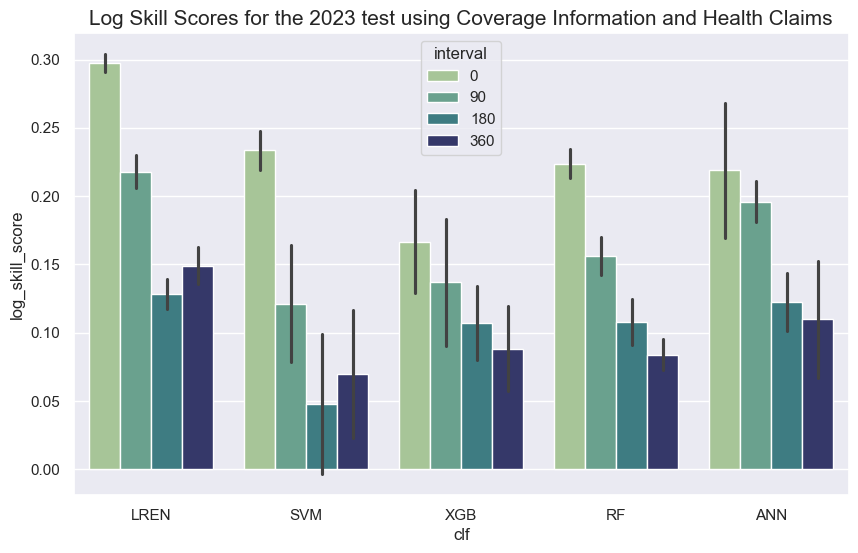

In [85]:
#Log loss skill score plot 2023 data
fig, ax = plt.subplots(figsize=(10,6))
query = 'year==2023'
result = cls_results_all.query(query)
sns.barplot(data=result, y='log_skill_score', x=result['clf'].str.upper(), 
            hue='interval', ax=ax, orient='v', palette='crest', errorbar='sd')
ax.set_title('Log Skill Scores for the 2023 test using Coverage Information and Health Claims')
ax.title.set_size(15)
ax.legend(loc='upper center', title='interval')
plt.show()

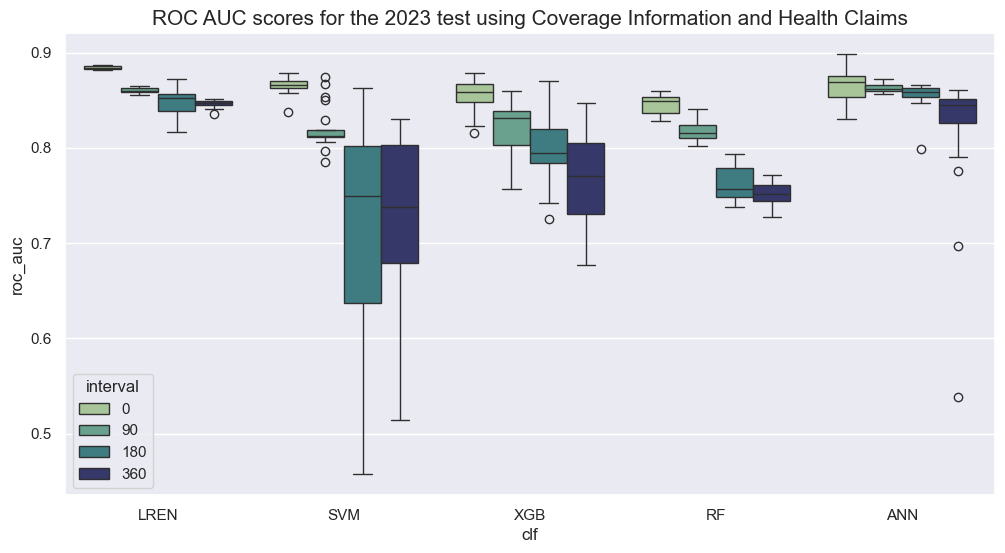

In [86]:
#ROC-AUC plot 2023 data
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2023'
result = cls_results_all.query(query).copy()
sns.boxplot(data=result, y='roc_auc', x=result['clf'].str.upper(), hue='interval', ax=ax, orient='v', palette='crest')
ax.set_title('ROC AUC scores for the 2023 test using Coverage Information and Health Claims')
ax.title.set_size(15)
ax.legend(loc='lower left', title='interval')
plt.show()

### 2024 test

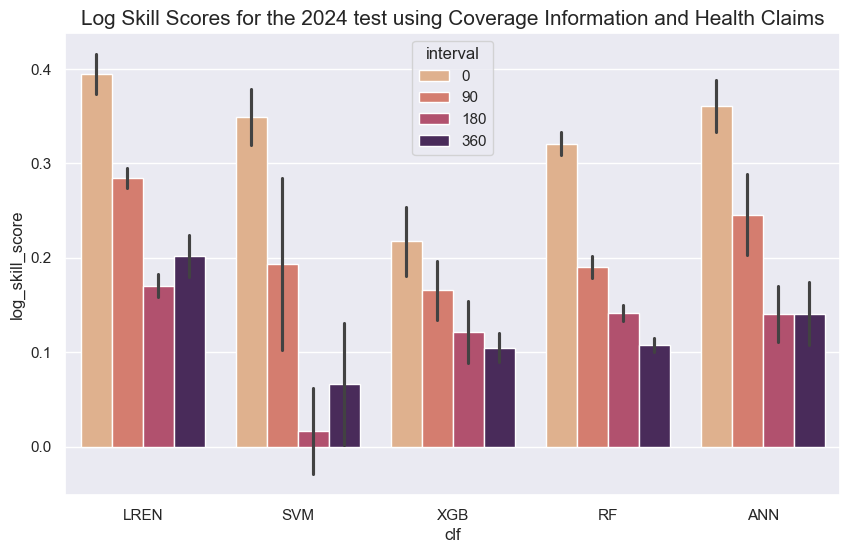

In [87]:
#Log loss skill score plot 2024 data
fig, ax = plt.subplots(figsize=(10,6))
query = 'year==2024'
result = cls_results_all.query(query)
sns.barplot(data=result, y='log_skill_score', x=result['clf'].str.upper(), 
            hue='interval', ax=ax, orient='v', palette='flare', errorbar='sd')
ax.set_title('Log Skill Scores for the 2024 test using Coverage Information and Health Claims')
ax.title.set_size(15)
ax.legend(loc='upper center', title='interval')
plt.show()

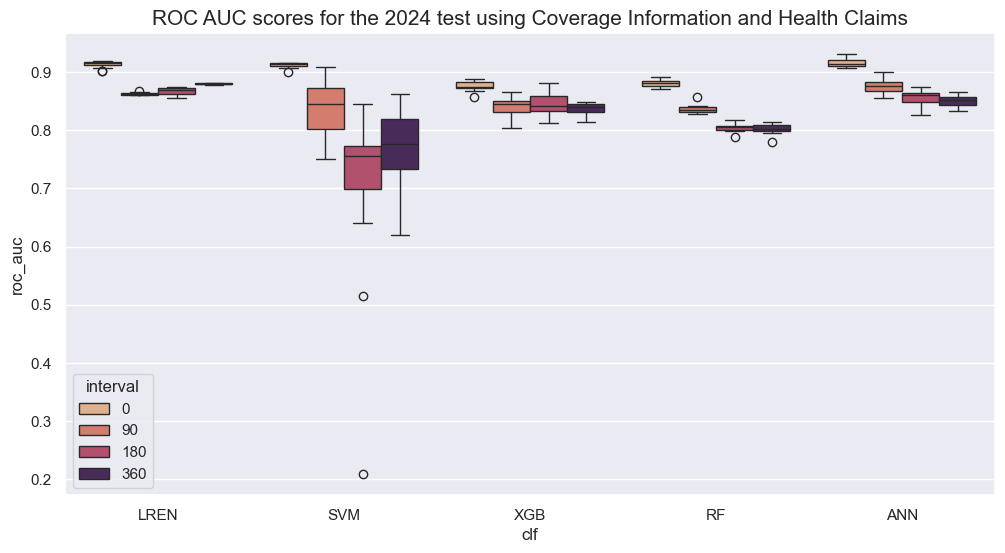

In [88]:
#ROC-AUC plot 2024 data
fig, ax = plt.subplots(figsize=(12,6))
query = 'year==2024'
result = cls_results_all.query(query).copy()
sns.boxplot(data=result, y='roc_auc', x=result['clf'].str.upper(), hue='interval', ax=ax, orient='v', palette='flare')
ax.set_title('ROC AUC scores for the 2024 test using Coverage Information and Health Claims')
ax.title.set_size(15)
ax.legend(loc='lower left', title='interval')
plt.show()

## Best mean results
We also search the results dataframe to identify the model with the best mean log loss skill score in each experiment.\
It appears that the Logistic Regression with Elastic Net gave the best probability estimates in all cases.

In [89]:
def best_clf_res(group):
    return group.loc[group['mean_log_skill'].idxmax(), :]

cls_means_calc = cls_results_all.groupby(['year', 'interval', 'clf'])\
                                .agg(mean_log_skill = ('log_skill_score', 'mean'),
                                     max_log_skill = ('log_skill_score', 'max'),
                                     min_log_skill = ('log_skill_score', 'min'),
                                     mean_auc = ('roc_auc', 'mean'),
                                     max_auc = ('roc_auc', 'max'),
                                     min_auc = ('roc_auc', 'min')
                                ).reset_index()

best_mean_scores = cls_means_calc.groupby(['year', 'interval'])\
                                 .apply(lambda g: best_clf_res(g), include_groups=False)\
                                 .reset_index()

In [90]:
best_mean_scores

,year,interval,clf,mean_log_skill,max_log_skill,min_log_skill,mean_auc,max_auc,min_auc
0,2023,0,lren,0.297,0.307,0.283,0.884,0.886,0.881
1,2023,90,lren,0.218,0.234,0.195,0.86,0.865,0.855
2,2023,180,lren,0.128,0.146,0.0973,0.847,0.873,0.816
3,2023,360,lren,0.149,0.16,0.102,0.846,0.851,0.835
4,2024,0,lren,0.395,0.418,0.359,0.914,0.919,0.901
5,2024,90,lren,0.284,0.301,0.259,0.862,0.868,0.86
6,2024,180,lren,0.17,0.186,0.137,0.867,0.874,0.856
7,2024,360,lren,0.202,0.224,0.149,0.88,0.882,0.878


In [91]:
best_mean_scores.to_csv('RESULTS/best_model_cvg_health_claims.csv', index=False)

## Demonstration of feature importance
Using the best model - the Logistic Regression with Elastic Net, we can now experiment with feature importance analysis. \
These are limited experiments using only the 0 day offset interval. Feature importances are scored 50 times and averaged. \
Also, note that calibrated classifiers use ensemble estimators. Feature importances are extracted from each submodel in the ensemble.

### 2023 test

In [92]:
pm.set_params(year=2023, interval=0) #Set parameters for the experiment
fi_scores_23 = pd.DataFrame(columns=model_cols)
start = time.time()
for i in range(0, 50, 1): #Repeat 50 times
    best_clf = pm.get_best_estimator(lren, cv_params_lren, 20, 5) #Get an optimised LREN clf
    #The estimator is an ensemble so we need to extract feature importances from each submodel
    for submodel in best_clf:
        submodel_fi = submodel.estimator['clf'].coef_[0]
        fi_score = pd.Series(data=submodel_fi, index=model_cols) #Extract feature importance scores
        fi_scores_23.loc[len(fi_scores_23), :] = fi_score
end = time.time()
print((end - start)/60)

10.426748526096343


In [93]:
fi_scores_23.shape

(250, 46)

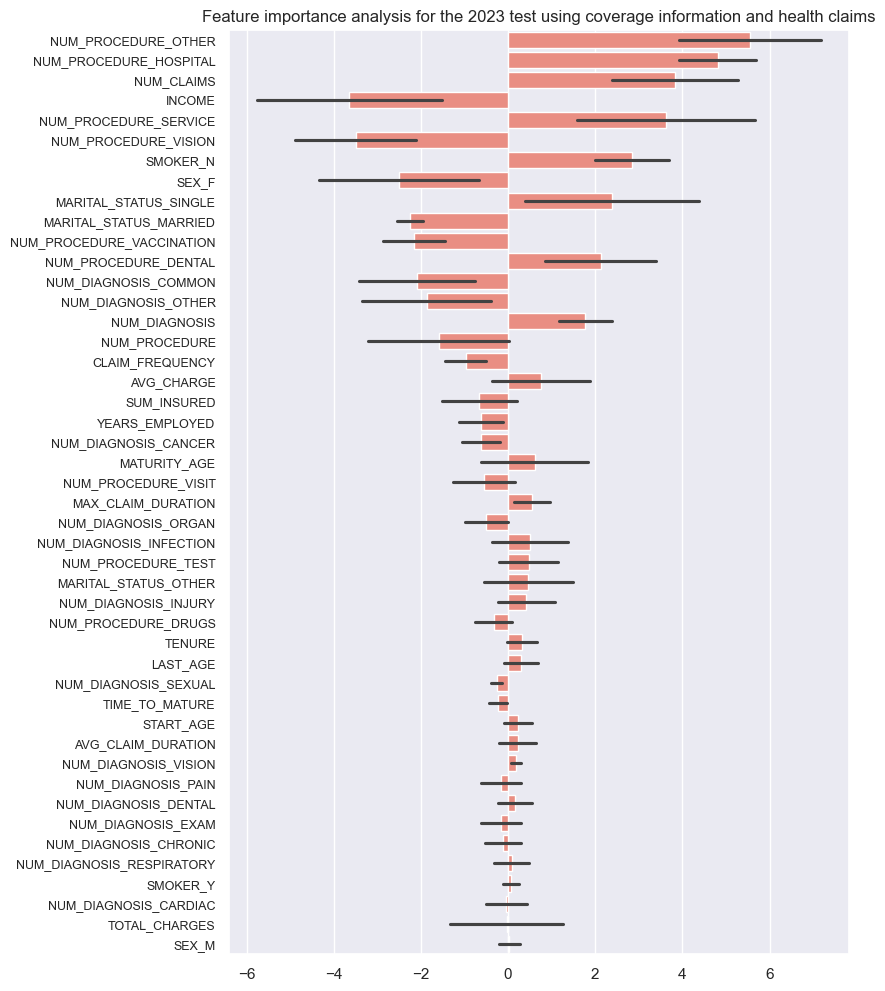

In [94]:
#Average the feature importance scores across the runs and plot
fig, ax = plt.subplots(figsize=(8,12))
feat_order = fi_scores_23.mean().sort_values(key=abs, ascending=False).index.values
sns.barplot(data=fi_scores_23, ax=ax, orient='h', color='salmon', errorbar='sd', order=feat_order)
ax.set_title('Feature importance analysis for the 2023 test using coverage information and health claims')
ax.title.set_size(12)
plt.yticks(fontsize=9)
plt.show()

### 2024 test

In [95]:
pm.set_params(year=2024, interval=0) #Set parameters for the experiment
fi_scores_24 = pd.DataFrame(columns=model_cols)
start = time.time()
for i in range(0, 50, 1): #Repeat 50 times
    best_clf = pm.get_best_estimator(lren, cv_params_lren, 20, 5) #Get an optimised LREN clf
    #The estimator is an ensemble so we need to extract feature importances from each submodel
    for submodel in best_clf:
        submodel_fi = submodel.estimator['clf'].coef_[0]
        fi_score = pd.Series(data=submodel_fi, index=model_cols) #Extract feature importance scores
        fi_scores_24.loc[len(fi_scores_24), :] = fi_score
end = time.time()
print((end - start)/60)

12.461459823449452


In [96]:
fi_scores_24.shape

(250, 46)

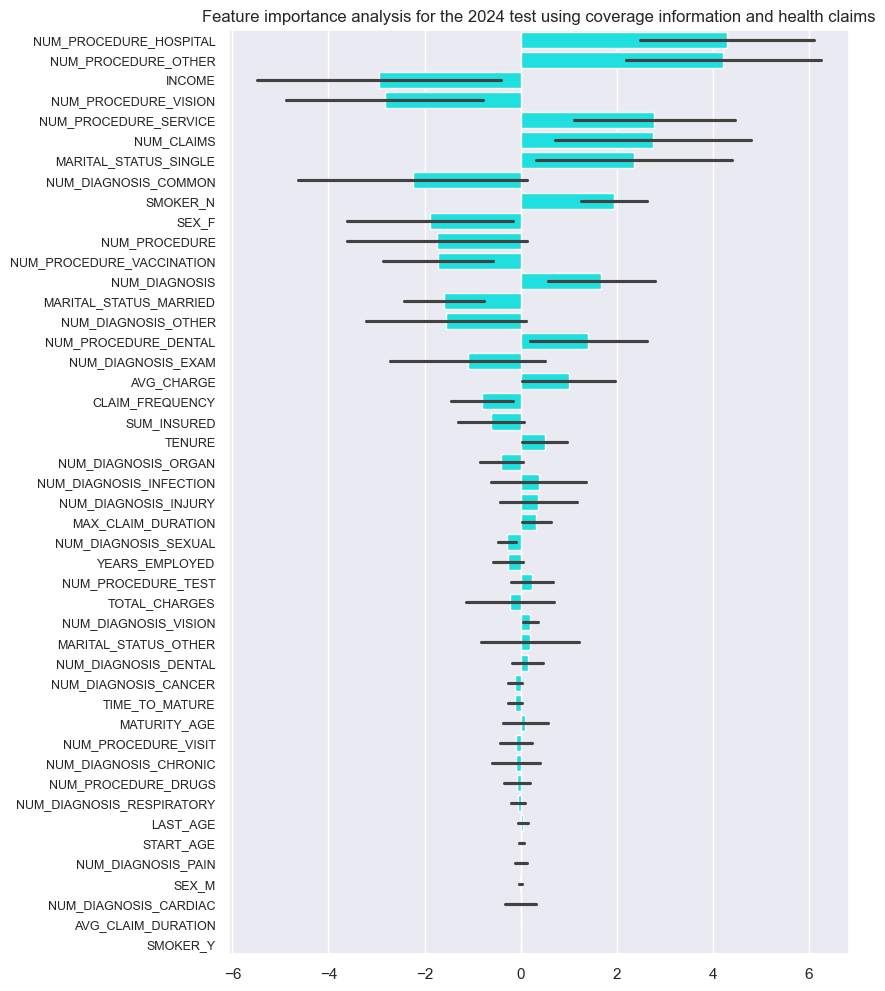

In [97]:
#Average the feature importance scores across the runs and plot
fig, ax = plt.subplots(figsize=(8,12))
feat_order = fi_scores_24.mean().sort_values(key=abs, ascending=False).index.values
sns.barplot(data=fi_scores_24, ax=ax, orient='h', color='cyan', errorbar='sd', order=feat_order)
ax.set_title('Feature importance analysis for the 2024 test using coverage information and health claims')
ax.title.set_size(12)
plt.yticks(fontsize=9)
plt.show()

# Rank Score
Lastly, the best performing model - the Logistic Regression with Elastic Net - is used to produce probability estimates for the coverages. These are then ranked in order of risk. Precision-at-K (PAK) and Recall-at-K (RAK) analysis is then performed. The experiment is repeated 20 times for numberical stability.

In [98]:
pm.set_params(test_years=[2023,2024], test_intervals=[0,90,180,360])
start = time.time()
ranking_results, mean_ranking_results = pm.repeated_ranking_analysis(lren, cv_params_lren, 20, 5, runs=20)
end = time.time()
print((end - start)/60)

31.889781868457796


In [99]:
print(ranking_results.shape, mean_ranking_results.shape)

(480, 6) (24, 6)


In [100]:
ranking_results.to_csv('RESULTS/ranking_results_cvg_health_claims.csv', index=False)

In [101]:
mean_ranking_results.to_csv('RESULTS/mean_ranking_results_cvg_health_claims.csv', index=False)

## 2023 test
Plots of the ranking analysis of the 2023 test.

In [102]:
mean_ranking_results.query('year==2023').sort_values(by=['interval', 'k'])

,year,interval,id,k,precision_at_k,recall_at_k
1,2023,0,Top10,10,0.645,0.358
2,2023,0,Top20,20,0.4,0.444
0,2023,0,Claim Rate,24,0.362,0.483
4,2023,90,Top10,10,0.595,0.331
5,2023,90,Top20,20,0.41,0.456
3,2023,90,Claim Rate,23,0.38,0.486
7,2023,180,Top10,10,0.2,0.111
8,2023,180,Top20,20,0.223,0.247
6,2023,180,Claim Rate,22,0.239,0.292
10,2023,360,Top10,10,0.29,0.161


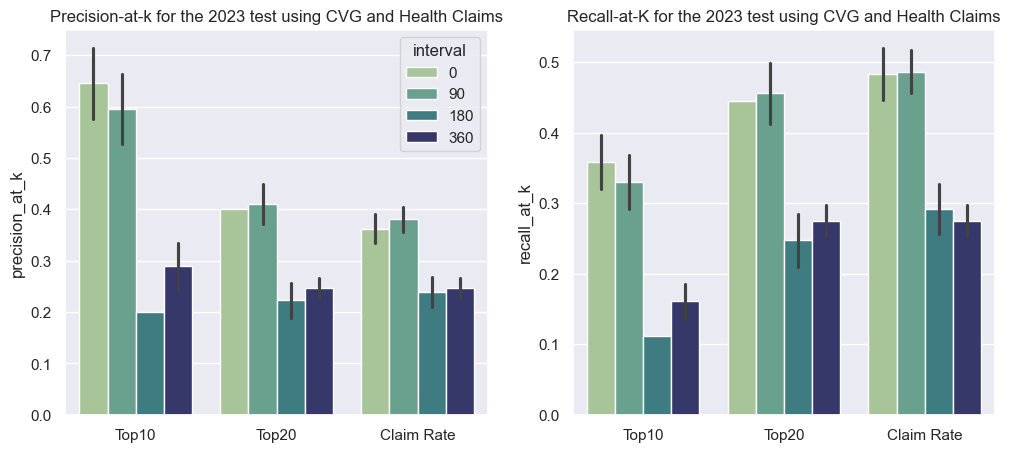

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
query = 'year==2023'
result = ranking_results.query(query).copy()
#Precision-at-k plot
sns.barplot(data=result, y='precision_at_k', x='id', hue='interval', ax=ax1, orient='v', errorbar='sd', palette='crest')
ax1.set_title('Precision-at-k for the 2023 test using CVG and Health Claims')
ax1.title.set_size(12)
ax1.set_xlabel('')
ax1.legend(loc='upper right', title='interval')
#Recall-at-k plot
sns.barplot(data=result, y='recall_at_k', x='id', hue='interval', ax=ax2, orient='v', errorbar='sd', palette='crest')
ax2.set_title('Recall-at-K for the 2023 test using CVG and Health Claims')
ax2.title.set_size(12)
ax2.set_xlabel('')
ax2.get_legend().remove()
plt.show()

## 2024 test
Plots of the ranking analysis of the 2024 test.

In [104]:
mean_ranking_results.query('year==2024').sort_values(by=['interval', 'k'])

,year,interval,id,k,precision_at_k,recall_at_k
12,2024,0,Claim Rate,10,0.6,0.5
13,2024,0,Top10,10,0.6,0.5
14,2024,0,Top20,20,0.478,0.796
15,2024,90,Claim Rate,10,0.6,0.5
16,2024,90,Top10,10,0.6,0.5
17,2024,90,Top20,20,0.4,0.667
18,2024,180,Claim Rate,9,0.444,0.333
19,2024,180,Top10,10,0.415,0.346
20,2024,180,Top20,20,0.35,0.583
21,2024,360,Claim Rate,9,0.444,0.333


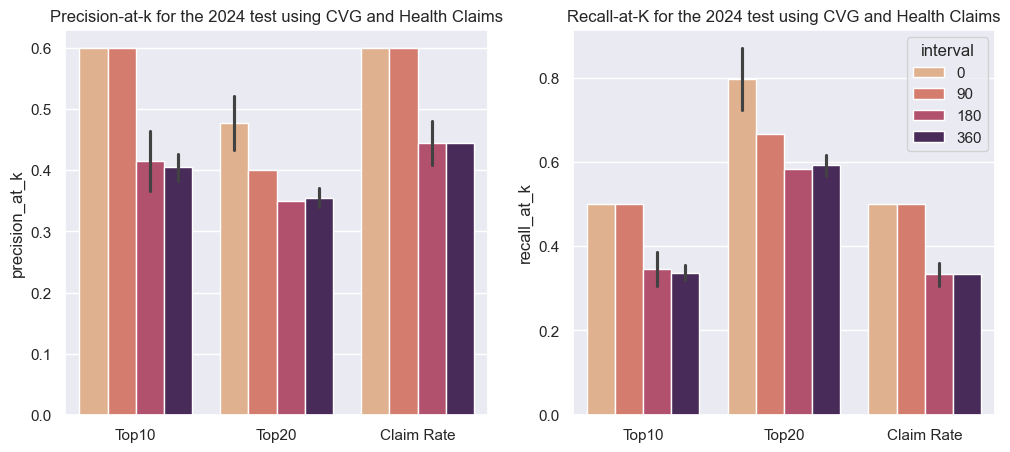

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
query = 'year==2024'
result = ranking_results.query(query).copy()
#Precision-at-k plot
sns.barplot(data=result, y='precision_at_k', x='id', hue='interval', ax=ax1, orient='v', errorbar='sd', palette='flare')
ax1.set_title('Precision-at-k for the 2024 test using CVG and Health Claims')
ax1.title.set_size(12)
ax1.get_legend().remove()
ax1.set_xlabel('')
#Recall-at-k plot
sns.barplot(data=result, y='recall_at_k', x='id', hue='interval', ax=ax2, orient='v', errorbar='sd', palette='flare')
ax2.set_title('Recall-at-K for the 2024 test using CVG and Health Claims')
ax2.title.set_size(12)
ax2.set_xlabel('')
plt.show()